# Load Dependencies

In [1]:
# -*- coding: unicode -*-

In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot as plt
import gensim
import nltk
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU
from keras.layers import Bidirectional, BatchNormalization, GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.
C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

In [4]:
assert gensim.models.doc2vec.FAST_VERSION > -1

In [5]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\insuf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\insuf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7616116616762234949
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 3129039257
locality {
  bus_id: 1
}
incarnation: 17930143205764048955
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0"
]


# Data Preprocessing

In [7]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

In [8]:
train = pd.read_csv('train_clean.csv')
train.comment_text = train.comment_text.astype(str)

In [9]:
list_classes = list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]

In [10]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
len(tokenizer.word_index)

223043

In [11]:
maxlen = 100
X_t = pad_sequences(list_tokenized_train,maxlen=maxlen,padding='post')

In [12]:
# description = train.comment_text.values.tolist()
# stop_words = set(nltk.corpus.stopwords.words('english'))


# # Function to filter stop words from tokens for each sentence
# def sentence_filter(sentence_token, stop_words):
#     filtered = []
#     for token in sentence_token:
#         if not token in stop_words:
#             filtered.append(token)
#     return filtered


# # Input description, tokenize each sentence and return token for each sentence without stopping words
# def sentence_tokenizer(description, stop_words):
#     value = []
#     for sentence in description:
#         sentence = sentence.lower()
#         tokenizer_ = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z]+')
#         sentence_token = tokenizer_.tokenize(sentence)
#         # sentence_token = nltk.word_tokenize(sentence)
#         filtered_token = sentence_filter(sentence_token, stop_words)
#         value.append(filtered_token)
#     return value


# # Tokenize the sentence
# description_token = sentence_tokenizer(description, stop_words)

In [13]:
# Skip gram model with minimum word count = 10 and output vector of length 300
# model_sg = gensim.models.Word2Vec(description_token, window=2, min_count=10, size=300, workers=4, seed=123, iter=10)

In [14]:
# model_sg.save('model_sg')

In [15]:
model_sg = gensim.models.Word2Vec.load('model_sg')

embed_size = 300
embeddings_index = dict()
for word in model_sg.wv.vocab:
    embeddings_index[word] = model_sg.wv[word]
print('Loaded %s word vectors.' % len(embeddings_index))

nb_words = min(max_features, len(tokenizer.word_index))
embedding_matrix = np.zeros((nb_words, embed_size))

embeddedCount = 0
for word, i in tokenizer.word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
print('total embedded:',embeddedCount,'common words')

Loaded 25653 word vectors.
total embedded: 19861 common words


In [16]:
embedding_matrix.shape

(20000, 300)

In [17]:
def auc(y_true, y_pred):
     auc = tf.metrics.auc(y_true, y_pred)[1]
     K.get_session().run(tf.local_variables_initializer())
     return auc

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_t, y, train_size=0.9, random_state=123)

C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [99]:
model = Sequential()
model.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen))
model.add(Bidirectional(LSTM(100,dropout=0.1,recurrent_dropout=0.1)))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(6, activation="sigmoid"))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_17 (Dense)             (None, 50)                10050     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 306       
Total params: 6,331,156
Trainable params: 6,331,156
Non-trainable params: 0
_________________________________________________________________


In [20]:
# plot_model(model, to_file='model.png')

In [100]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
# checkpoint = ModelCheckpoint(filepath='best.hdf5',monitor='val_loss',verbose=1, save_best_only=True)

In [101]:
cw = {0:1, 1:10, 2:90, 3:17, 4:300, 5:18, 6:102}

In [102]:
with tf.device('/gpu:0'):
    history = model.fit(X_train,y_train,
                        validation_data=(X_val, y_val),
                        batch_size=256,
                        epochs=20,
                        class_weight=cw,
                        callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/20
143613/143613 [==============================] - 212s 1ms/step - loss: 0.4698 - auc: 0.7571 - val_loss: 0.1007 - val_auc: 0.8316
Epoch 2/20
143613/143613 [==============================] - 215s 1ms/step - loss: 0.3293 - auc: 0.8617 - val_loss: 0.0870 - val_auc: 0.8807
Epoch 3/20
143613/143613 [==============================] - 223s 2ms/step - loss: 0.2363 - auc: 0.8943 - val_loss: 0.0881 - val_auc: 0.9036
Epoch 4/20
143613/143613 [==============================] - 217s 2ms/step - loss: 0.1645 - auc: 0.9123 - val_loss: 0.0857 - val_auc: 0.9193
Epoch 5/20
143613/143613 [==============================] - 210s 1ms/step - loss: 0.1190 - auc: 0.9253 - val_loss: 0.0824 - val_auc: 0.9308
Epoch 6/20
143613/143613 [==============================] - 209s 1ms/step - loss: 0.0989 - auc: 0.9353 - val_loss: 0.0739 - val_auc: 0.9392
Epoch 7/20
143613/143613 [==============================] - 215s 1ms/step - loss: 0.0778 - auc: 0.9426 - val_

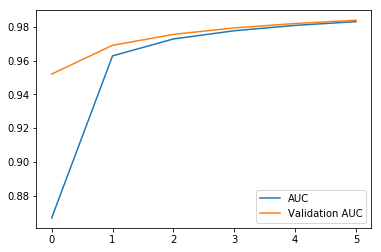

In [109]:
plt.plot(history.history['auc'], label="AUC")
plt.plot(history.history['val_auc'], label="Validation AUC")
plt.legend()
plt.show()

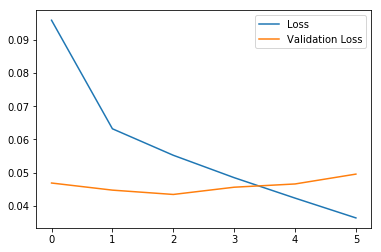

In [110]:
plt.plot(history.history['loss'], label="Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.show()

In [105]:
val_predict = (np.asarray(model.predict([X_val], batch_size=512))).round()
val_target = y_val

val_precision = []
val_recall = []
val_f1 = []
for i in range(6):
    val_precision.append(metrics.precision_score(val_target[:,i], val_predict[:,i]))
    val_recall.append(metrics.recall_score(val_target[:,i], val_predict[:,i]))
    val_f1.append(metrics.f1_score(val_target[:,i], val_predict[:,i]))

print("Validation Precision: {},\n\nValidation Recall: {},\n\nValidation F1: {}".format(val_precision, val_recall, val_f1))

Validation Precision: [0.7980535279805353, 0.45333333333333331, 0.74534883720930234, 0.27272727272727271, 0.67079889807162529, 0.38157894736842107],

Validation Recall: [0.6776859504132231, 0.22666666666666666, 0.78940886699507384, 0.066666666666666666, 0.65369127516778525, 0.24786324786324787],

Validation F1: [0.73296089385474861, 0.30222222222222223, 0.76674641148325351, 0.10714285714285715, 0.66213460231135279, 0.30051813471502592]


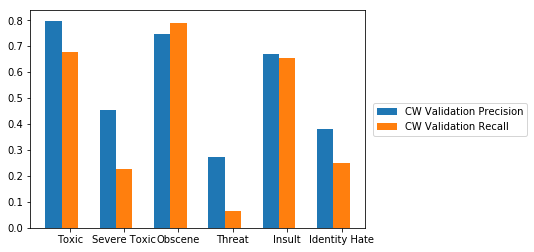

In [106]:
names = ["Toxic", "Severe Toxic", "Obscene", "Threat", "Insult", "Identity Hate"]

plt.bar(np.arange(6) - 0.3/2,val_precision,0.3,label="CW Validation Precision", tick_label=names)
plt.bar(np.arange(6) + 0.3/2,val_recall,0.3,label="CW Validation Recall", tick_label=names)
plt.legend(loc='right', bbox_to_anchor=(1.5,0.5))
plt.show()

# With class weight in place, it is harder for the network to train and converge, consequently taking extra epochs to compensate for the underclass samples. It takes 17 epochs to reach a good enough model, but comparing to no-class-weight baseline models, the AUC and loss for train and validation are both higher. 

## Need better class weights or alternative approach(oversample, undersample, cross-validation).

# Undersample!

In [52]:
model1 = Sequential()
model1.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen))
model1.add(Bidirectional(LSTM(100,dropout=0.1,recurrent_dropout=0.1)))
model1.add(Dense(50, activation="relu"))
model1.add(Dropout(0.1))
model1.add(Dense(6, activation="sigmoid"))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_9 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 306       
Total params: 6,331,156
Trainable params: 6,331,156
Non-trainable params: 0
_________________________________________________________________


In [53]:
y_majority_index = np.where(np.sum(y_train, axis=1)==0)[0]
y_minority_index = np.where(np.sum(y_train, axis=1)!=0)[0]
n_undersample = y_majority_index.shape[0]*0.1

rauc = []
rval_auc = []
rloss = []
rval_loss = []

while True:
    index_undersample = np.random.choice(y_majority_index,int(n_undersample),replace=False)
    new_index_undersample = np.concatenate([y_minority_index, index_undersample])
    x_train_new = X_train[new_index_undersample,:]
    y_train_new = y_train[new_index_undersample,:]
    with tf.device('/gpu:0'):
        hist = model1.fit(x_train_new,y_train_new,validation_data=(X_val, y_val),batch_size=256,epochs=1)
    rauc.append(hist.history["auc"])
    rval_auc.append(hist.history["val_auc"])
    rloss.append(hist.history["loss"])
    rval_loss.append(hist.history["val_loss"])
    if rval_loss[-1] > rloss[-1]:
        break

Train on 27593 samples, validate on 15958 samples
Epoch 1/1
27593/27593 [==============================] - 45s 2ms/step - loss: 0.2922 - auc: 0.8262 - val_loss: 0.0826 - val_auc: 0.9187
Train on 27593 samples, validate on 15958 samples
Epoch 1/1
27593/27593 [==============================] - 43s 2ms/step - loss: 0.2034 - auc: 0.9360 - val_loss: 0.0676 - val_auc: 0.9451
Train on 27593 samples, validate on 15958 samples
Epoch 1/1
27593/27593 [==============================] - 44s 2ms/step - loss: 0.1854 - auc: 0.9511 - val_loss: 0.0660 - val_auc: 0.9550
Train on 27593 samples, validate on 15958 samples
Epoch 1/1
27593/27593 [==============================] - 37s 1ms/step - loss: 0.1723 - auc: 0.9582 - val_loss: 0.0578 - val_auc: 0.9607
Train on 27593 samples, validate on 15958 samples
Epoch 1/1
27593/27593 [==============================] - 37s 1ms/step - loss: 0.1611 - auc: 0.9631 - val_loss: 0.0614 - val_auc: 0.9648
Train on 27593 samples, validate on 15958 samples
Epoch 1/1
27593/2759

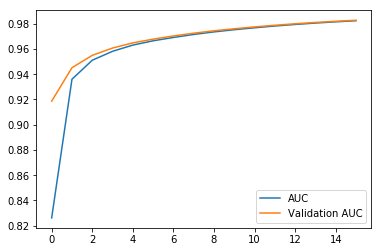

In [54]:
plt.plot(rauc, label="AUC")
plt.plot(rval_auc, label="Validation AUC")
plt.legend()
plt.show()

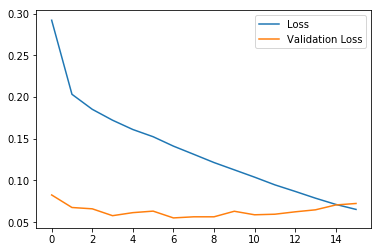

In [55]:
plt.plot(rloss, label="Loss")
plt.plot(rval_loss, label="Validation Loss")
plt.legend()
plt.show()

In [56]:
val_predict1 = (np.asarray(model1.predict([X_val], batch_size=512))).round()

val_precision1 = []
val_recall1 = []
val_f11 = []
for i in range(6):
    val_precision1.append(metrics.precision_score(val_target[:,i], val_predict1[:,i]))
    val_recall1.append(metrics.recall_score(val_target[:,i], val_predict1[:,i]))
    val_f11.append(metrics.f1_score(val_target[:,i], val_predict1[:,i]))

print("Validation Precision: {},\n\nValidation Recall: {},\n\nValidation F1: {}".format(val_precision1, val_recall1, val_f11))

Validation Precision: [0.62411347517730498, 0.37142857142857144, 0.73266219239373598, 0.39130434782608697, 0.6440049443757726, 0.46153846153846156],

Validation Recall: [0.84848484848484851, 0.26000000000000001, 0.80665024630541871, 0.20000000000000001, 0.69932885906040265, 0.51282051282051277],

Validation F1: [0.71920607122008162, 0.30588235294117644, 0.76787807737397429, 0.26470588235294118, 0.67052767052767059, 0.48582995951417002]


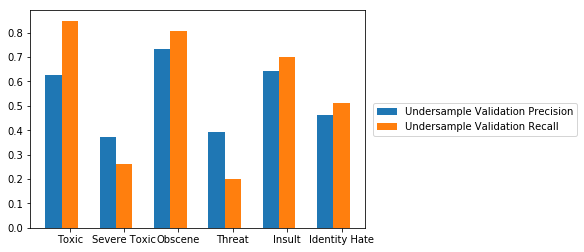

In [64]:
plt.bar(np.arange(6) - 0.3/2,val_precision1,0.3,label="Undersample Validation Precision", tick_label=names)
plt.bar(np.arange(6) + 0.3/2,val_recall1,0.3,label="Undersample Validation Recall", tick_label=names)
plt.legend(loc='right', bbox_to_anchor=(1.65,0.5))
plt.show()

# Way better result comparing to Class Weights. Took 15 epochs.

# Undersample and penalize at the same time.

In [ ]:
model2 = Sequential()
model2.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen))
model2.add(Bidirectional(LSTM(100,dropout=0.1,recurrent_dropout=0.1)))
model2.add(Dense(50, activation="relu"))
model2.add(Dropout(0.1))
model2.add(Dense(5, activation="sigmoid"))
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
model2.summary()

In [ ]:
y_majority_index = np.where(np.sum(y_train, axis=1)==0)[0]
y_minority_index = np.where(np.sum(y_train, axis=1)!=0)[0]
n_undersample = y_majority_index.shape[0]*0.1

r2auc = []
r2val_auc = []
r2loss = []
r2val_loss = []

cw = {0:1, 1:30, 2:5, 3:100, 4:6, 5:30}

while True:
    index_undersample = np.random.choice(y_majority_index,int(n_undersample),replace=False)
    new_index_undersample = np.concatenate([y_minority_index, index_undersample])
    x_train_new = X_train[new_index_undersample,:]
    y_train_new = y_train[new_index_undersample,:]
    with tf.device('/gpu:0'):
        hist = model2.fit(x_train_new,y_train_new,validation_data=(X_val, y_val),batch_size=256,epochs=1,class_weight=cw,)
    r2auc.append(hist.history["auc"])
    r2val_auc.append(hist.history["val_auc"])
    r2loss.append(hist.history["loss"])
    r2val_loss.append(hist.history["val_loss"])
    if r2val_loss[-1] > r2loss[-1]:
        break

In [ ]:
plt.plot(r2auc, label="AUC")
plt.plot(r2val_auc, label="Validation AUC")
plt.legend()
plt.show()

In [ ]:
plt.plot(r2loss, label="Loss")
plt.plot(r2val_loss, label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
val_predict2 = (np.asarray(model2.predict([X_val], batch_size=512))).round()

val_precision2 = []
val_recall2 = []
val_f12 = []
for i in range(6):
    val_precision2.append(metrics.precision_score(val_target[:,i], val_predict2[:,i]))
    val_recall2.append(metrics.recall_score(val_target[:,i], val_predict2[:,i]))
    val_f12.append(metrics.f1_score(val_target[:,i], val_predict2[:,i]))

print("Validation Precision: {},\n\nValidation Recall: {},\n\nValidation F1: {}".format(val_precision2, val_recall2, val_f12))

In [107]:
model = Sequential()
model.add(Embedding(max_features,embed_size,weights=[embedding_matrix],input_length=maxlen))
model.add(Bidirectional(LSTM(100,dropout=0.1,recurrent_dropout=0.1)))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(6, activation="sigmoid"))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[auc])
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
import math
def create_class_weight(labels_dict):
    total = sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

labels_dict = {0: 143346, 1: 15294, 2: 1595, 3: 8449, 4: 478, 5: 7877, 6: 1405}
cw = create_class_weight(labels_dict)
with tf.device('/gpu:0'):
    history = model.fit(X_train,y_train,
                        validation_data=(X_val, y_val),
                        batch_size=256,
                        epochs=20,
                        class_weight=cw,
                        callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/20
143613/143613 [==============================] - 210s 1ms/step - loss: 0.0958 - auc: 0.8669 - val_loss: 0.0469 - val_auc: 0.9520
Epoch 2/20
143613/143613 [==============================] - 208s 1ms/step - loss: 0.0632 - auc: 0.9627 - val_loss: 0.0448 - val_auc: 0.9690
Epoch 3/20
143613/143613 [==============================] - 207s 1ms/step - loss: 0.0553 - auc: 0.9728 - val_loss: 0.0435 - val_auc: 0.9755
Epoch 4/20
143613/143613 [==============================] - 208s 1ms/step - loss: 0.0485 - auc: 0.9776 - val_loss: 0.0457 - val_auc: 0.9793
Epoch 5/20
143613/143613 [==============================] - 207s 1ms/step - loss: 0.0424 - auc: 0.9808 - val_loss: 0.0467 - val_auc: 0.9819
Epoch 6/20
143613/143613 [==============================] - 206s 1ms/step - loss: 0.0365 - auc: 0.9830 - val_loss: 0.0496 - val_auc: 0.9838


In [108]:
val_predict = (np.asarray(model.predict([X_val], batch_size=512))).round()
val_target = y_val

val_precision = []
val_recall = []
for i in range(6):
    val_precision.append(metrics.precision_score(val_target[:,i], val_predict[:,i]))
    val_recall.append(metrics.recall_score(val_target[:,i], val_predict[:,i]))

print("Validation Precision: {},\n\nValidation Recall: {}".format(val_precision, val_recall))

Validation Precision: [0.78621169916434541, 0.41025641025641024, 0.79201934703748489, 0.5714285714285714, 0.70738255033557051, 0.48863636363636365],

Validation Recall: [0.77754820936639113, 0.32000000000000001, 0.80665024630541871, 0.17777777777777778, 0.70738255033557051, 0.36752136752136755]
